<a href="https://colab.research.google.com/github/insaiyancvk/speedyblackman/blob/main/speedy_work_turns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Starting with Left/Right work

In [1]:
from google.colab import drive
drive._mount('/content/drive')
from IPython.display import Image
!pip install -q python-telegram-bot

Mounted at /content/drive
     |████████████████████████████████| 495 kB 4.1 MB/s 
     |████████████████████████████████| 428 kB 38.3 MB/s 
     |████████████████████████████████| 58 kB 6.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires tornado~=5.1.0; python_version >= "3.0", but you have tornado 6.1 which is incompatible.


TRY MOBILENETV2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os, telegram, json, cv2, time, random, zipfile, shutil
from math import floor
from PIL import Image

import torch
import torchvision

from torch.utils.data import DataLoader
from torch.cuda.amp import autocast
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# from torchvision.models.resnet import resnet50
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"{device} activated.")

cuda activated.


In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

In [3]:
print("Initializing kaggle")
!rm -rf /root/.kaggle && mkdir /root/.kaggle && cp /content/drive/MyDrive/kaggle.json . && mv kaggle.json /root/.kaggle/kaggle.json

print("Downloading the dataset")
!kaggle datasets download -d insaiyancvk/directions-nfsr

print("Extracting the dataset")
with zipfile.ZipFile("directions-nfsr.zip") as zf:
  for member in tqdm(zf.infolist(), desc='Extracting'):
    try:
      zf.extract(member, "/content")
    except zipfile.error:
      pass
!rm directions-nfsr.zip

Initializing kaggle
100% 10.3G/10.3G [03:37<00:00, 35.0MB/s]
100% 10.3G/10.3G [03:38<00:00, 50.6MB/s]
Extracting the dataset


Extracting:   0%|          | 0/52185 [00:00<?, ?it/s]

In [19]:
#@title Telegram bot
class send(): 

  def __init__(self):
    f = open ('/content/drive/MyDrive/tel.json', 'r')
    self.tel = json.load(f)
    f.close()
    self.bot = telegram.Bot(token=self.tel['token']) 

  def msg(self, mesg):
    self.bot.sendMessage(chat_id=self.tel['nnboiid'], text=mesg)

  def pic(self, path):
    self.bot.sendPhoto(chat_id=self.tel['nnboiid'], photo=open(path, 'rb'))
bot = send()

In [4]:
print("Initializing classes")

class_list = [
              'a',
              'center',
              'd']

print("Creating workspace")

drive = os.path.join("drive","MyDrive")
FOLDERS = {
    "TRAIN": os.path.join("train"),
    "TEST": os.path.join("test"),
    "WORKSPACE": os.path.join(drive,"speedata","workspace"),
    "MODELS": os.path.join(drive,"speedata","workspace","models"),
    "PERFORMANCE": os.path.join(drive,"speedata","workspace","performance")
}

for key in FOLDERS:
  if not os.path.isdir(FOLDERS[key]):
    print(key, "directory doesn't exist. Creating one.")
    os.mkdir(FOLDERS[key])
    print(key, "directory created.")

Initializing classes
Creating workspace


In [ ]:
from PIL import Image, ImageFilter

In [5]:
def cropper(path):
  im = Image.open(path)
  im = im.crop((0,300,1920,500))
  im.save(path)
  del im

### Experimenting on image sizes and edges

In [ ]:
image = Image.open(FOLDERS['TRAIN']+'/a/'+os.listdir(FOLDERS['TRAIN']+'/a/')[0])

In [ ]:
cropper(FOLDERS['TRAIN']+'/a/'+os.listdir(FOLDERS['TRAIN']+'/a/')[0])

In [ ]:
display(image)

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
gray = cv2.cvtColor(hsv, cv2.COLOR_BGR2GRAY)

In [ ]:
cv2_imshow(gray)

In [ ]:
path = FOLDERS['TRAIN']+'/a/'+os.listdir(FOLDERS['TRAIN']+'/a/')[1]
cropper(path)
frame = cv2.imread(path)
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
     
# Calculation of Sobelx
sobelx = cv2.Sobel(frame,cv2.CV_64F,1,0,ksize=5)
  
# Calculation of Sobely
sobely = cv2.Sobel(frame,cv2.CV_64F,0,1,ksize=5)
  
# Calculation of Laplacian
laplacian = cv2.Laplacian(frame,cv2.CV_64F)

In [ ]:
cv2_imshow(laplacian)

In [ ]:
path

'train/a/798a3908234e11eca7aa842afd0f58b8.jpg'

In [ ]:
path = FOLDERS['TRAIN']+'/d/'+os.listdir(FOLDERS['TRAIN']+'/d/')[950]
cv2_imshow(cv2.imread(path))
cropper(path)
frame = cv2.imread(path)

In [ ]:
cv2_imshow(frame)

In [ ]:
edges = cv2.Canny(frame, threshold1=1, threshold2=300)
cv2_imshow(edges)

In [ ]:
path = FOLDERS['TRAIN']+'/d/'+os.listdir(FOLDERS['TRAIN']+'/d/')[745]

In [ ]:
path

'train/d/cd38b55d220011ec938c842afd0f58b8.jpg'

In [ ]:
op = Image.open(path)

In [ ]:
display(op)

In [ ]:
# path = FOLDERS['TRAIN']+'/a/'+os.listdir(FOLDERS['TRAIN']+'/a/')[199]
cropper(path)
img = Image.open(path)
# img = trans(Image.open(path)).numpy()
# img = img.swapaxes(0,1)
# img = img.swapaxes(1,2)
plt.imshow(img)

In [ ]:
trans = transforms.Compose([
                      transforms.Resize([512,512]),
                      # transforms.CenterCrop(size)
                      transforms.ToTensor(),
                      # transforms.Normalize((0.25,0.25,0.25),(0.75,0.75,0.75))
                      transforms.Normalize((0.19,0.19,0.19), (0.6,0.6,0.6))
    ])

### Cropping all images

In [6]:
testdir = {
    'a':'/content/test/a',
    'center':'/content/test/center',
    'd': '/content/test/d'
}
traindir = {
    'a':'/content/train/a',
    'center':'/content/train/center',
    'd': '/content/train/d'
}

In [7]:
for name in os.listdir(traindir['a']):
  cropper(traindir['a']+f'/{name}')
print('Cropping train,left complete')
for name in os.listdir(traindir['center']):
  cropper(traindir['center']+f'/{name}')
print('Cropping train,center complete')
for name in os.listdir(traindir['d']):
  cropper(traindir['d']+f'/{name}')
print('Cropping train/right complete')

Cropping train,left complete
Cropping train,center complete
Cropping train/right complete


In [8]:
for name in os.listdir(testdir['a']):
  cropper(testdir['a']+f'/{name}')
print('Cropping test,left complete')
for name in os.listdir(testdir['center']):
  cropper(testdir['center']+f'/{name}')
print('Cropping test,center complete')
for name in os.listdir(testdir['d']):
  cropper(testdir['d']+f'/{name}')
print('Cropping test/right complete')

Cropping test,left complete
Cropping test,center complete
Cropping test/right complete


In [ ]:
display(Image.open(FOLDERS['TRAIN']+'/a/'+os.listdir(FOLDERS['TRAIN']+'/a/')[0]))

### Defining the transformations on train and test data

In [9]:
print("Defining the transformations for the speedy data")
transformations = {
    "TRAIN": transforms.Compose([
                        transforms.Resize([256,256]),
                        transforms.ColorJitter(brightness=(0.8,1.5), contrast=(0.8,1.5), saturation=(0.8,1.5)),
                        transforms.RandomAffine(degrees = 5, translate= (0.1, 0.1), scale=None, shear=None, resample=False, fillcolor=0),
                        # transforms.RandomInvert(0.5),
                        # transforms.RandomRotation(degrees=(-10,10)),
                        transforms.ToTensor(),
                        # transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ]),
    "TEST": transforms.Compose([
                      transforms.Resize([256,256]),
                      transforms.ToTensor(),
                      # transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ])
}

Defining the transformations for the speedy data


### Define dataset of the _speedata_

In [10]:
print("Creating a dataset of the speedata")
dataset = {
    "TRAIN": datasets.ImageFolder(
        FOLDERS["TRAIN"],
        transform = transformations["TRAIN"]
    ),
    "TEST": datasets.ImageFolder(
        FOLDERS["TEST"],
        transform = transformations["TEST"]
    )
}

Creating a dataset of the speedata


### Create Dataloader of the _speedata_

In [11]:
BATCH =  32#@param {type:"integer"}

In [12]:
print("Creating dataloaders")
dataloader = {
    "TRAIN": DataLoader(
        dataset["TRAIN"],
        batch_size = BATCH,
        shuffle = True
    ),
    "TEST": DataLoader(
        dataset["TEST"],
        batch_size = BATCH,
        shuffle = True
    )
}
print("Data preprocessing completed.")

Creating dataloaders
Data preprocessing completed.


# The G

In [13]:
#@title Epoch function

def epoch(model, test_loader ,train_loader, loss_func, optim, device):

  test_loss = 0
  test_accuracy = 0
  train_loss = 0
  train_accuracy = 0

  model = model.to(device)

  print("\t\tTraining the Neural Network")
  model.train(True)
  for image, label in tqdm(train_loader):
      optim.zero_grad()      
      with autocast():
        output = model.forward(image.to(device).half())
      # output = model(image.to(device))
      loss = loss_func(
        output,
        label.to(device)
        )
      loss.backward()
      optim.step()

      accuracy = np.average(
            np.argmax(
              output.cpu().detach().numpy(), axis=1) == label.cpu().detach().numpy()
        )

      train_loss += loss.item()/len(train_loader) # training average loss
      train_accuracy += accuracy/len(train_loader) # training average accuracy
  model.train(False)

  print("\t\tValidating Neural Network")
  model.eval()

  for image, label in tqdm(test_loader):
      with autocast():
        output = model.forward(image.to(device).half())
      # output = model(image.to(device))
      loss = loss_func(
        output,
        label.to(device)
      )
      
      accuracy = np.average(
        np.argmax(
            output.cpu().detach().numpy(), axis=1) == label.cpu().detach().numpy()
        )

      test_loss += loss.item()/len(test_loader) # Validation average loss
      test_accuracy += accuracy/len(test_loader) # Validation average accuracy
      
  return (

    # TRAIN LOSS
    train_loss,

    # TRAIN ACCURACY
    train_accuracy,

    # TEST LOSS, ACCURACY
    test_loss,
    test_accuracy
  )

In [14]:
EPOCH =  15#@param {type:"integer"}

In [ ]:
!pip install -q pretrainedmodels
import pretrainedmodels

[Reference](https://medium.com/analytics-vidhya/how-to-add-additional-layers-in-a-pre-trained-model-using-pytorch-5627002c75a5)

In [ ]:
#@title Resnet18 extra layers

class Resnet18(nn.Module):
  def __init__(self):
      super(Resnet18, self).__init__()
      self.model =  pretrainedmodels.__dict__['resnet18'](pretrained='imagenet')
      
      self.classifier_layer = nn.Sequential(
          nn.Linear(512 , 256),
          nn.BatchNorm1d(256),
          nn.Dropout(0.2),
          nn.Linear(256 , 128),
          nn.Linear(128 , 2)
      )

  def forward(self, x):
    batch_size ,_,_,_ = x.shape     #taking out batch_size from input image
    x = self.model.features(x)
    x = torch.nn.functional.adaptive_avg_pool2d(x,1).reshape(batch_size,-1)     # then reshaping the batch_size
    x = self.classifier_layer(x)
    return x
# model = Resnet18()
# model.fc = nn.Linear(model.fc.in_features,2)
# model.fc.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.5, training=m.training)) # add a dropout layer

In [ ]:
#@title install efficientnet
!pip install efficientnet_pytorch

In [ ]:
#@title import efficientnet
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=2)

In [ ]:
#@title AlexNet [reference](https://github.com/dansuh17/alexnet-pytorch/blob/master/model.py)
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = AlexNet()
!wget https://download.pytorch.org/models/alexnet-owt-7be5be79.pth
model.load_state_dict(torch.load("/content/alexnet-owt-7be5be79.pth"))
model.classifier[6] = nn.Linear(in_features=4096, out_features = 3)

In [16]:
#@title MobileNetV2
torch.hub._validate_not_a_forked_repo=lambda a,b,c: True
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=False)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=1280, out_features = 3)
)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
#@title
# LeNet-5
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

- Try LeNet, VGG-16, Inception V1, DenseNet, GoogLeNet

In [17]:
NAME = f"MobileNetV2turnsCroppedimgsNoNorm"
# NAME = f"AlexNetCroppedimgs"
LR = 0.001

# model.load_state_dict(torch.load(f"/content/drive/MyDrive/speedata/workspace/models/{NAME}.pth"))
# model.load_state_dict(torch.load("/content/alexnet-owt-7be5be79.pth"))

MobileNetV2turnsCroppedimgsNoNorm INITIALIZED
Epoch: 1/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/1305 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/327 [00:00<?, ?it/s]

Test Loss: 0.611 Test Accuracy: 0.664
Train Loss: 0.836 Train Accuracy: 0.538
Time: 18.59 min(s)
Epoch: 2/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/1305 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/327 [00:00<?, ?it/s]

Test Loss: 0.488 Test Accuracy: 0.738
Train Loss: 0.570 Train Accuracy: 0.696
Time: 36.59 min(s)
Epoch: 3/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/1305 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/327 [00:00<?, ?it/s]

Test Loss: 0.459 Test Accuracy: 0.764
Train Loss: 0.505 Train Accuracy: 0.738
Time: 54.62 min(s)
Improvement detected. Saving the model

Epoch: 4/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/1305 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/327 [00:00<?, ?it/s]

Test Loss: 0.457 Test Accuracy: 0.769
Train Loss: 0.479 Train Accuracy: 0.756
Time: 72.64 min(s)
Improvement detected. Saving the model

Epoch: 5/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/1305 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/327 [00:00<?, ?it/s]

Test Loss: 0.428 Test Accuracy: 0.784
Train Loss: 0.457 Train Accuracy: 0.766
Time: 90.68 min(s)
Improvement detected. Saving the model

Epoch: 6/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/1305 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/327 [00:00<?, ?it/s]

Test Loss: 0.415 Test Accuracy: 0.792
Train Loss: 0.442 Train Accuracy: 0.779
Time: 108.73 min(s)
Improvement detected. Saving the model

Epoch: 7/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/1305 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/327 [00:00<?, ?it/s]

Test Loss: 0.410 Test Accuracy: 0.796
Train Loss: 0.432 Train Accuracy: 0.788
Time: 126.85 min(s)
Improvement detected. Saving the model

Epoch: 8/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/1305 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/327 [00:00<?, ?it/s]

Test Loss: 0.419 Test Accuracy: 0.791
Train Loss: 0.417 Train Accuracy: 0.793
Time: 144.98 min(s)
Epoch: 9/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/1305 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/327 [00:00<?, ?it/s]

Test Loss: 0.396 Test Accuracy: 0.807
Train Loss: 0.412 Train Accuracy: 0.798
Time: 163.22 min(s)
Improvement detected. Saving the model

Epoch: 10/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/1305 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/327 [00:00<?, ?it/s]

Test Loss: 0.383 Test Accuracy: 0.814
Train Loss: 0.400 Train Accuracy: 0.803
Time: 181.50 min(s)
Improvement detected. Saving the model

Epoch: 11/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/1305 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/327 [00:00<?, ?it/s]

Test Loss: 0.386 Test Accuracy: 0.814
Train Loss: 0.389 Train Accuracy: 0.810
Time: 199.73 min(s)
Epoch: 12/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/1305 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/327 [00:00<?, ?it/s]

Test Loss: 0.389 Test Accuracy: 0.814
Train Loss: 0.382 Train Accuracy: 0.814
Time: 217.97 min(s)
Epoch: 13/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/1305 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/327 [00:00<?, ?it/s]

Test Loss: 0.364 Test Accuracy: 0.827
Train Loss: 0.375 Train Accuracy: 0.818
Time: 236.26 min(s)
Improvement detected. Saving the model

Epoch: 14/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/1305 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/327 [00:00<?, ?it/s]

Test Loss: 0.360 Test Accuracy: 0.830
Train Loss: 0.369 Train Accuracy: 0.824
Time: 254.31 min(s)
Improvement detected. Saving the model

Epoch: 15/15
LR: 0.001
		Training the Neural Network


  0%|          | 0/1305 [00:00<?, ?it/s]

		Validating Neural Network


  0%|          | 0/327 [00:00<?, ?it/s]

Test Loss: 0.359 Test Accuracy: 0.832
Train Loss: 0.361 Train Accuracy: 0.828
Time: 272.50 min(s)
Improvement detected. Saving the model

Total time taken to train for 15 epochs on MobileNetV2turnsCroppedimgsNoNorm: 272.59 min(s)
82.81% highest train accuracy at 14 epoch and 83.19% highest test accuracy at 14 epoch


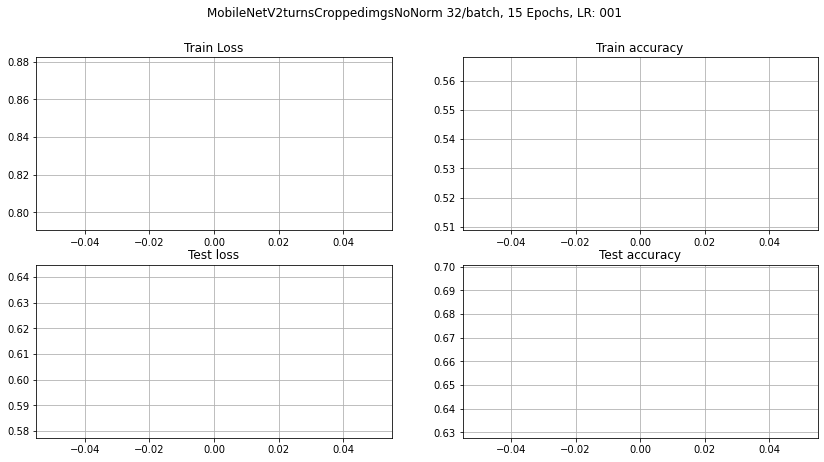

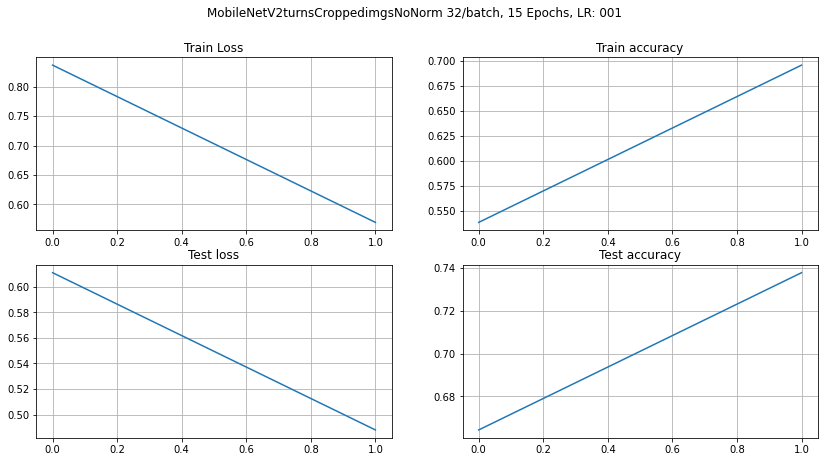

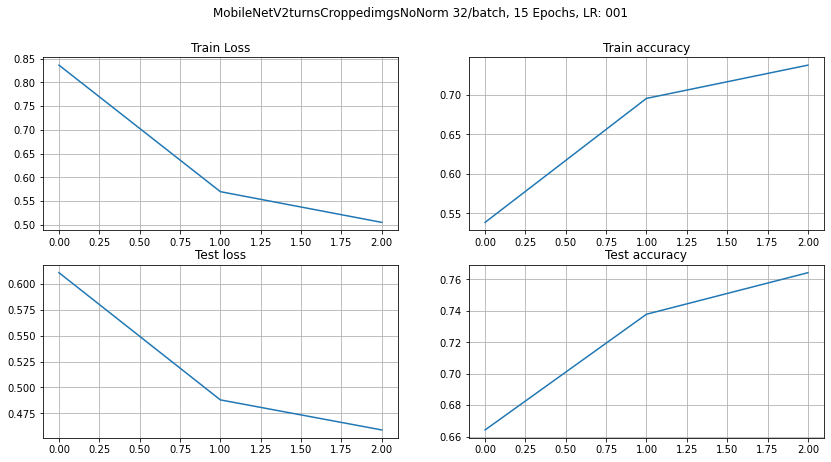

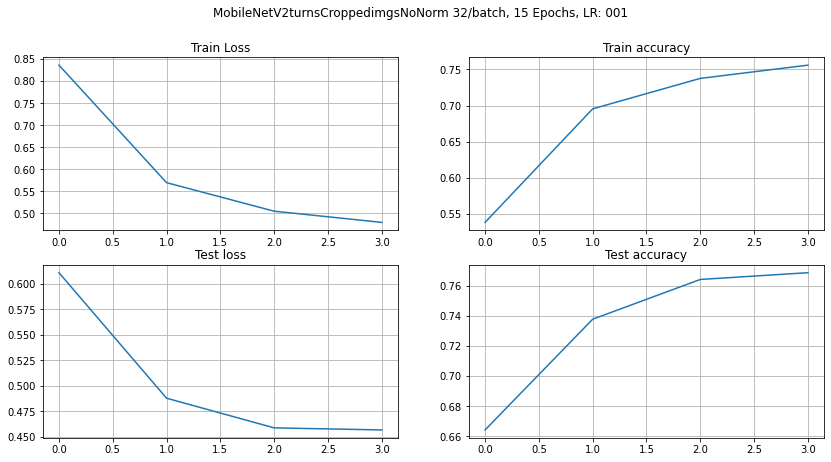

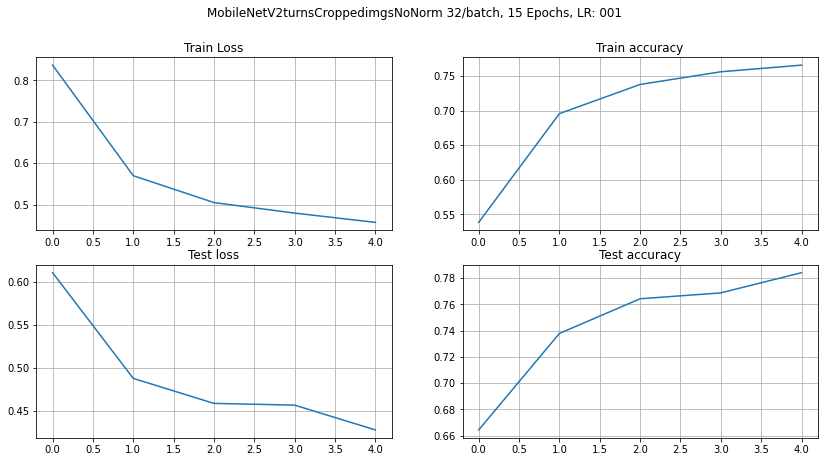

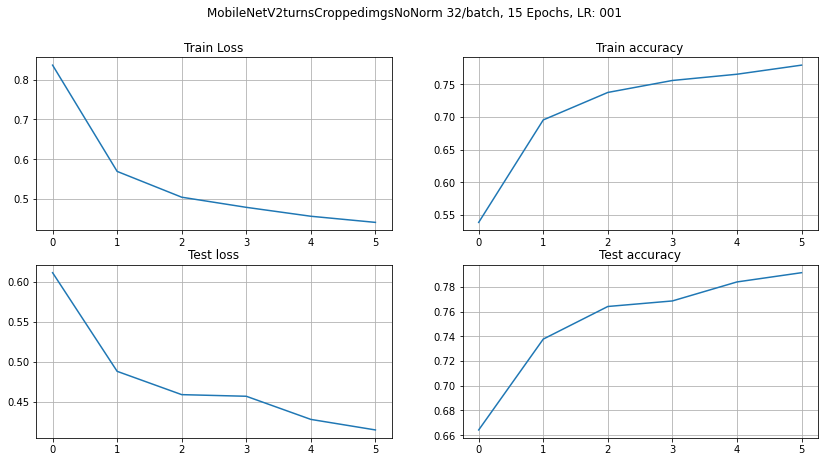

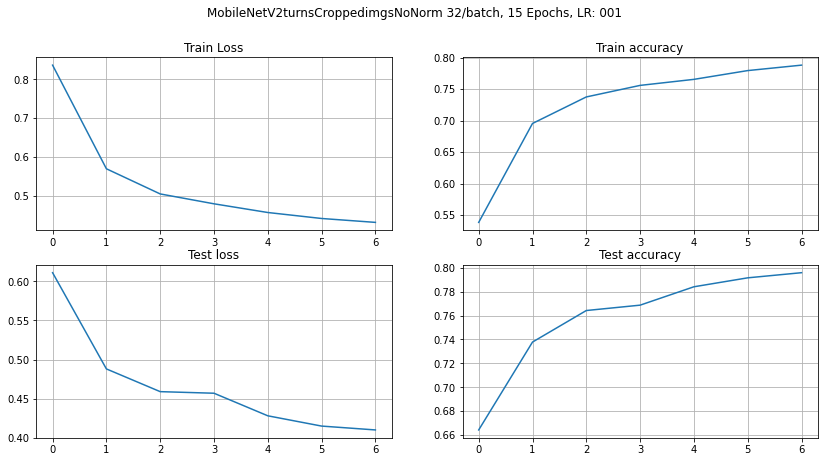

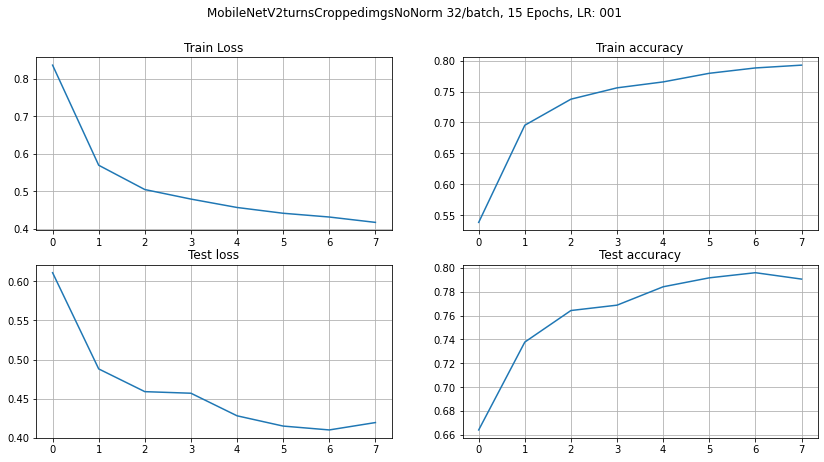

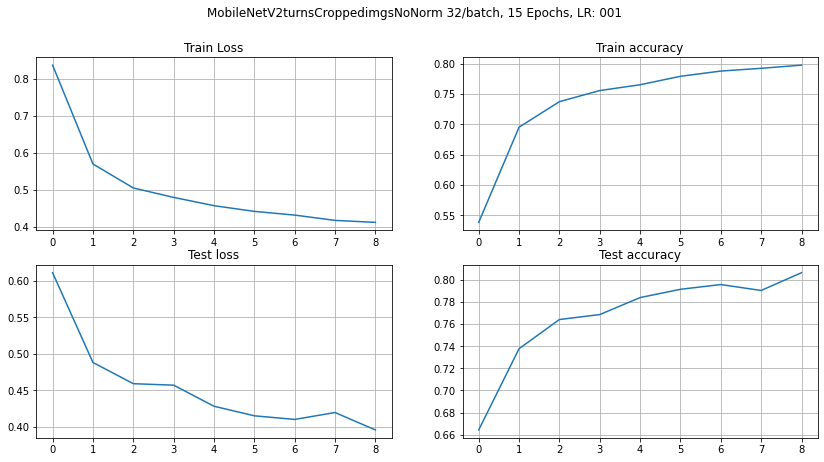

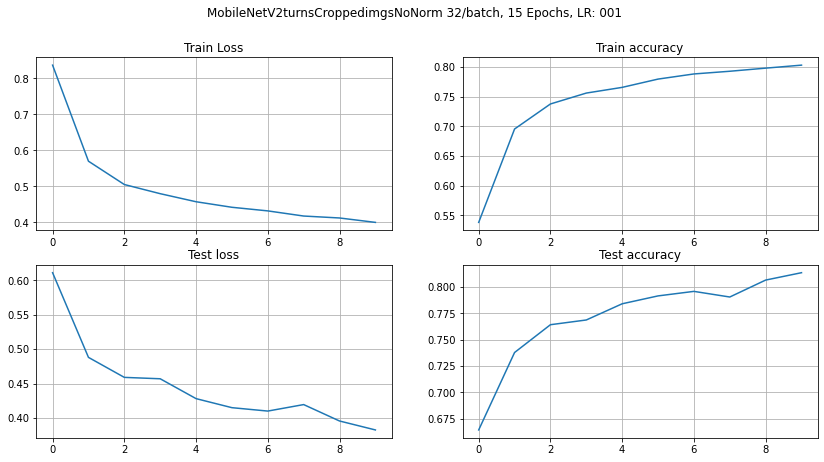

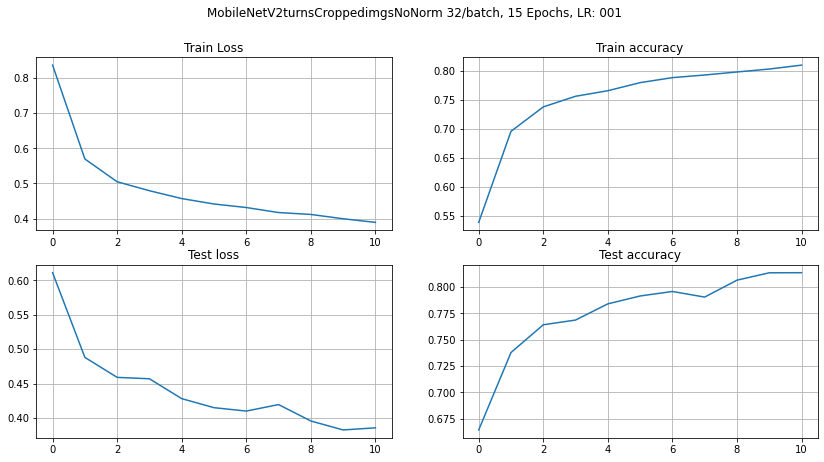

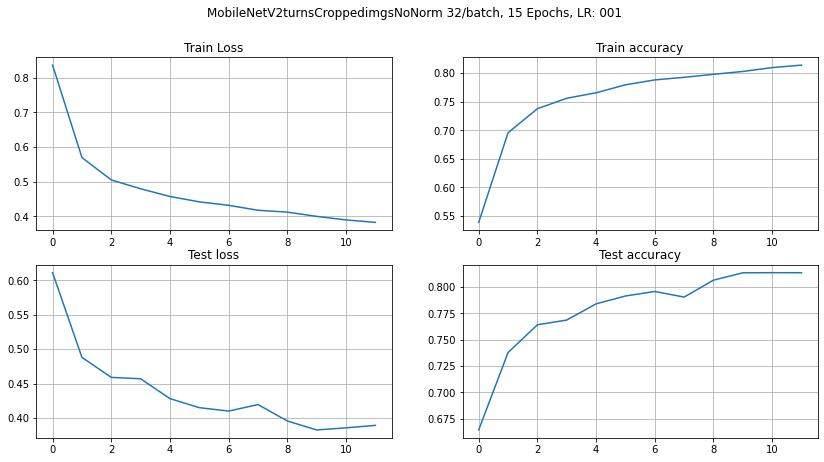

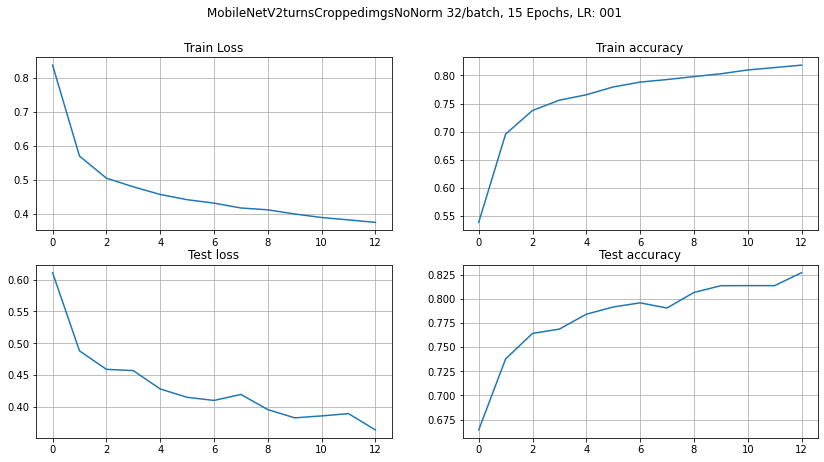

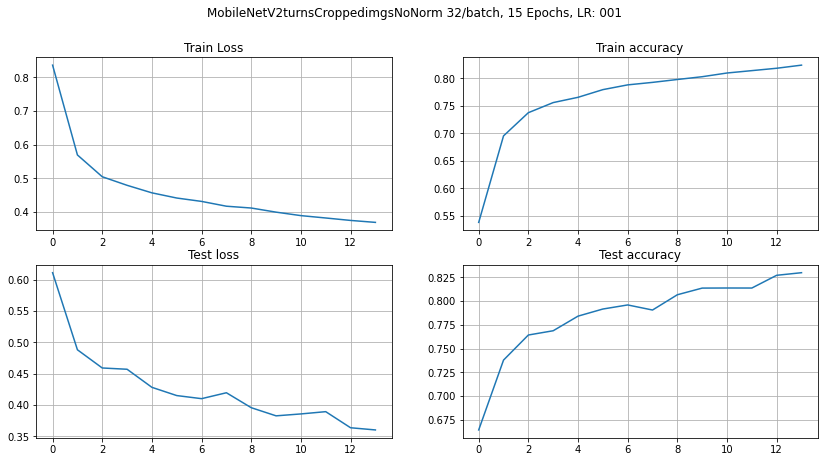

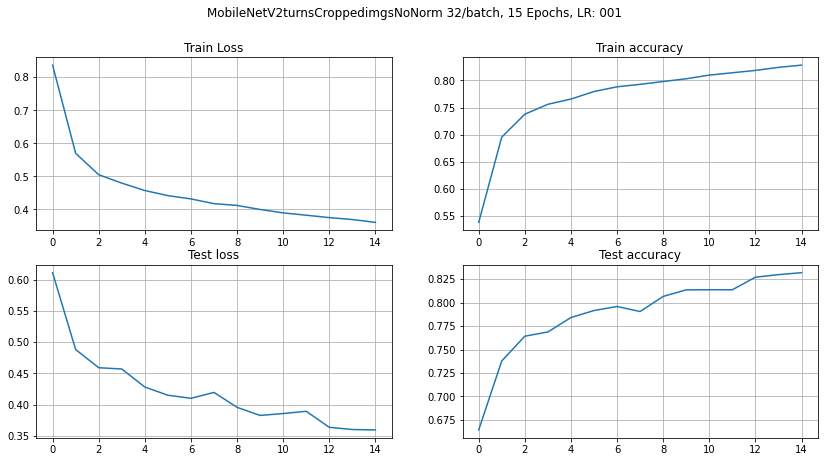

In [20]:
done = False

model = model.to(device)

print(f"{NAME} INITIALIZED")
send().msg(f"{NAME} INITIALIZED")

loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)

train_loss_vals = []
train_accuracy_vals = []
test_loss_vals = []
test_accuracy_vals = []

start = time.time()
for ep in range(EPOCH):
  messages = ''

  print(f"Epoch: {ep+1}/{EPOCH}\nLR: {optimizer.param_groups[0]['lr']}")
  messages += f"\nEpoch: {ep+1}/{EPOCH}\nLR: {optimizer.param_groups[0]['lr']}" # for telegram

  vals = epoch(model, dataloader["TEST"], dataloader["TRAIN"], loss_func, optimizer, device)
  train_loss_vals.append(vals[0])
  train_accuracy_vals.append(vals[1])
  test_loss_vals.append(vals[2])
  test_accuracy_vals.append(vals[3])

  print(f"Test Loss: {test_loss_vals[-1]:.3f} Test Accuracy: {test_accuracy_vals[-1]:.3f}")
  print(f"Train Loss: {train_loss_vals[-1]:.3f} Train Accuracy: {train_accuracy_vals[-1]:.3f}")
  messages += f"\nTest Loss: {test_loss_vals[-1]:.3f} Test Accuracy: {test_accuracy_vals[-1]:.3f}" # for telegram
  messages += f"\nTrain Loss: {train_loss_vals[-1]:.3f} Train Accuracy: {train_accuracy_vals[-1]:.3f}"
  print(f"Time: {(time.time()-start)/60:.2f} min(s)")
  messages += f"\nTime elapsed: {(time.time()-start)/60:.2f} min(s)" # for telegram
  
  if len(test_loss_vals)>2:
    if all(x > test_loss_vals[-1] for x in test_loss_vals[:-1]):
      model_name = os.path.join(FOLDERS["MODELS"],f"{NAME}.pth")
      
      print(f"Improvement detected. Saving the model\n")
      messages += f"\nImprovement detected. Saving the model" # for telegram

      torch.save(model.state_dict(),model_name)
  fig, a = plt.subplots(2,2, squeeze=False, figsize=(14,7))
  a[0][0].plot(train_loss_vals)
  a[0][0].set_title("Train Loss")
  a[0][0].grid(True)
  a[0][1].plot(train_accuracy_vals)
  a[0][1].set_title("Train accuracy")
  a[0][1].grid(True)
  a[1][0].plot(test_loss_vals)
  a[1][0].set_title("Test loss")
  a[1][0].grid(True)
  a[1][1].plot(test_accuracy_vals)
  a[1][1].set_title("Test accuracy")
  a[1][1].grid(True)
  fig.suptitle(f"{NAME} {BATCH}/batch, {EPOCH} Epochs, LR: {str(optimizer.param_groups[0]['lr']).replace('0.','')}\n")
  # plt.show()
  if ep>2:
    performanceplot = f"PERFORMANCE.jpg"
    fig.savefig(performanceplot)
    send().pic(performanceplot)
  send().msg(messages)
  send().msg('———————————————————————')

print(f"Total time taken to train for {EPOCH} epochs on {NAME}: {(time.time()-start)/60:.2f} min(s)")
send().msg(f"Total time taken to train for {EPOCH} epochs {NAME}: {(time.time()-start)/60:.2f} min(s)")
print(f"{max(train_accuracy_vals)*100:.2f}% highest train accuracy at {train_accuracy_vals.index(max(train_accuracy_vals))} epoch and {max(test_accuracy_vals)*100:.2f}% highest test accuracy at {test_accuracy_vals.index(max(test_accuracy_vals))} epoch")
send().msg(f"{max(train_accuracy_vals)*100:.2f}% highest train accuracy at {train_accuracy_vals.index(max(train_accuracy_vals))} epoch and {max(test_accuracy_vals)*100:.2f}% highest test accuracy at {test_accuracy_vals.index(max(test_accuracy_vals))} epoch")
done = True

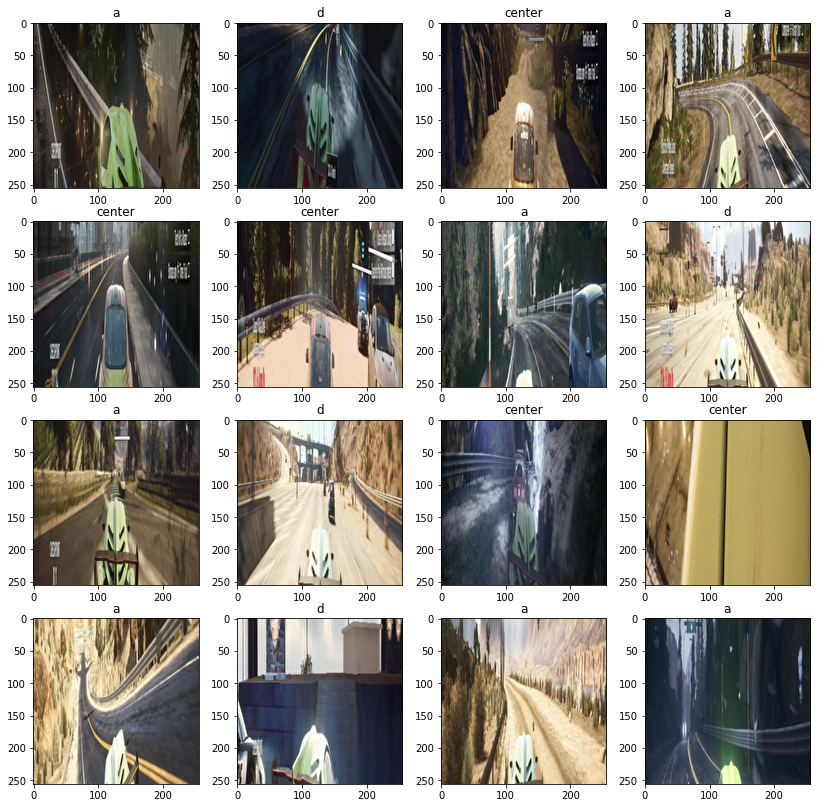

<Figure size 720x216 with 0 Axes>

<Figure size 3600x3600 with 0 Axes>

In [22]:
# emotions = ['disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral', 'angry']
fig, axs = plt.subplots(4, 4, figsize=(14,14))
fig = plt.figure(figsize=(10,3))
trans = transforms.ToPILImage()
plt.figure(figsize=(50,50))

for i in range(4):
    for j in range(4):
        for image_list in (dataloader["TEST"]):

            p_image=image_list[0][0]
            x=p_image.squeeze()

            x = x.swapaxes(0,1)
            x = x.swapaxes(1,2)
            axs[j,i].imshow(x, interpolation='sinc', cmap='gray')

            with torch.no_grad():

              model.eval()
              p_image=p_image.cuda()
              lab=model(p_image.unsqueeze(0))
              lab=lab.cpu()
              max_index = np.argmax(lab[0]) 
              predicted_emotion = class_list[max_index]
            
            axs[j,i].title.set_text(predicted_emotion)
            break

plt.show()

In [ ]:
fig, a = plt.subplots(2,2, squeeze=False, figsize=(14,7))
a[0][0].plot(train_loss_vals)
a[0][0].set_title("Train Loss")
a[0][0].grid(True)
a[0][1].plot(train_accuracy_vals)
a[0][1].set_title("Train accuracy")
a[0][1].grid(True)
a[1][0].plot(test_loss_vals)
a[1][0].set_title("Test loss")
a[1][0].grid(True)
a[1][1].plot(test_accuracy_vals)
a[1][1].set_title("Test accuracy")
a[1][1].grid(True)
fig.suptitle(f"MobileNetDirections {BATCH}/batch, {EPOCH} Epochs, LR: {str(optimizer.param_groups[0]['lr']).replace('0.','')}\n")
plt.show()
performanceplot = f"{FOLDERS['PERFORMANCE']}/{NAME}.jpg"
fig.savefig(performanceplot)
send().pic(performanceplot)

In [ ]:
%reset